In [435]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

In [436]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(
    n_samples=500, centers=centers, cluster_std=0.4, random_state=0
)

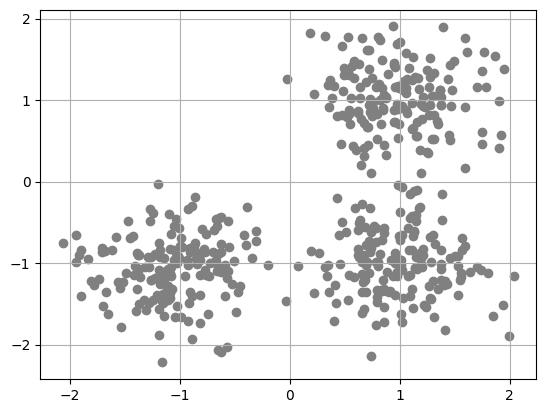

In [437]:
fig1, ax1 = plt.subplots()

ax1.scatter(X[:, 0], X[:, 1], c='grey')
ax1.grid(True)
plt.show()

Variables that influence the density-based clustering algorithm

epsilon:  maximum distance between two points to be considered neighbors

minPts:  minimum number of points required within neighborhood for a point to be considered a core point. 

In [438]:
eps = 0.2
min_pts = 4

In [439]:
def get_equclidean_distance(pt1, pt2):
    dist = np.sqrt(
        (pt2[0]-pt1[0])**2+(pt2[1]-pt1[1])**2
        )
    
    return dist

Get core points

In [440]:
def get_core_points(data_set):

    core_points = []
    for center_idx, center_point in enumerate(data_set):

        center_neighbors = []
        for idx, neighbor_point in enumerate(data_set):

            #  ommits the center point from being considered
            if center_idx!=idx:
                dist = get_equclidean_distance(pt1=center_point, pt2=neighbor_point)

                #  Identify center points with neighboring points within distance epsilon
                if dist<=eps:
                    center_neighbors.append(neighbor_point)


        #  Of center points points with neighbors, identify center points with at least the miniumum number of neighbors as core points
        number_of_neighbors = len(center_neighbors)
        if number_of_neighbors>=min_pts:
            core_points.append(center_point)

    return core_points

In [441]:
core_points = get_core_points(data_set=X)

In [442]:
x = [point[0] for point in core_points]
y = [point[-1] for point in core_points]

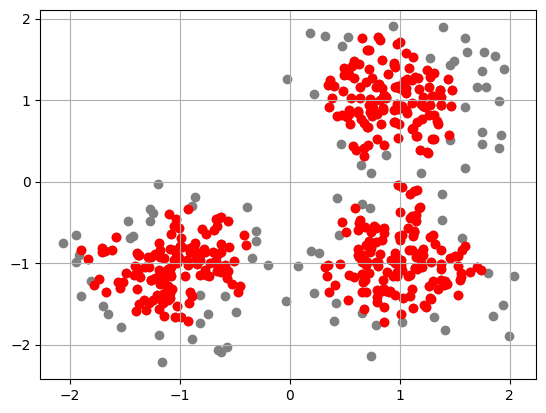

In [443]:
fig1, ax1 = plt.subplots()

ax1.scatter(X[:, 0], X[:, 1], c='grey')
ax1.scatter(x, y, c='red')
ax1.grid(True)
plt.show()

Get non-core neighbors

In [444]:
def get_non_core_points(data_set, core_points):
    
    non_core_points=[]
    for data_point in data_set:
        
        #  Identify core points in the input data set
        point_intersection=[]
        for core_point in core_points:
            common_pt = set(core_point)==set(data_point)
            point_intersection.append(common_pt)


        #  Only append values in the input data set that are NOT core points
        if not bool(sum(point_intersection)):
            non_core_points.append(data_point)

    return non_core_points

In [445]:
non_core_points = get_non_core_points(X, core_points)

In [446]:
#  non-core neighbors will join a cluster, but won't extend the cluster (i.e. will not make the cluster larger)
non_core_neighbors=[]

for nc_point in non_core_points:
    for c_point in core_points:

        dist = get_equclidean_distance(pt1=nc_point, pt2=c_point)
        
        #  Identify non-core points with neighboring core points within distance epsilon
        if dist<=eps:
            non_core_neighbors.append(nc_point)

In [447]:
p = [point[0] for point in non_core_neighbors]
q = [point[-1] for point in non_core_neighbors]

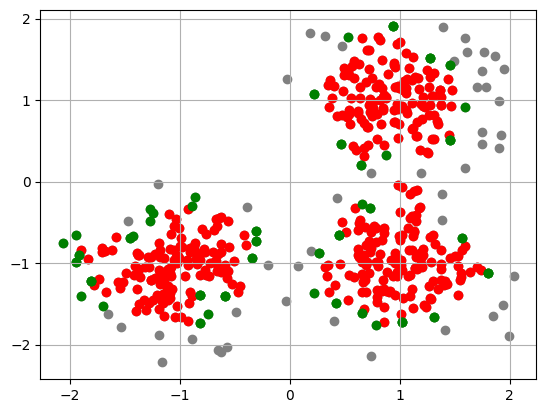

In [448]:
fig2, ax2 = plt.subplots()

ax2.scatter(X[:, 0], X[:, 1], c='grey')
ax2.scatter(x, y, c='red')
ax2.scatter(p, q, c='green')
ax2.grid(True)
plt.show()

In [449]:
core_points.extend(non_core_neighbors)

x = [point[0] for point in core_points]
y = [point[-1] for point in core_points]

Get outlier points

In [450]:
def get_outliers(data_set, core_points):
    
    outliers=[]
    for data_point in data_set:
        
        #  Identify outlier points in the input data set
        point_intersection=[]
        for core_point in core_points:
            common_pt = set(core_point)==set(data_point)
            point_intersection.append(common_pt)


        #  Only append values in the input data set that are NOT core points
        if not bool(sum(point_intersection)):
            outliers.append(data_point)

    return outliers

In [451]:
outliers = get_outliers(X, core_points)

In [452]:
r = [point[0] for point in outliers]
s = [point[-1] for point in outliers]

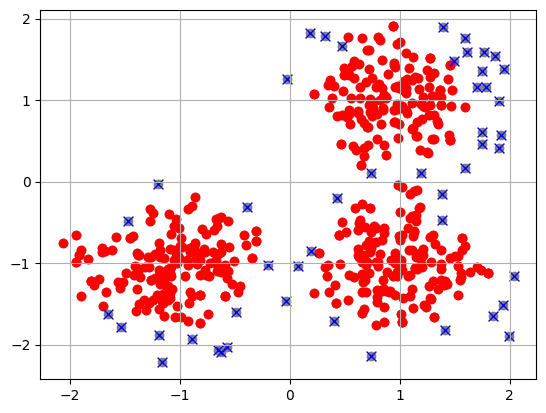

In [453]:
fig4, ax4 = plt.subplots()

ax4.scatter(X[:, 0], X[:, 1], c='grey')
ax4.scatter(x, y, c='red')
ax4.scatter(r, s, c='blue', marker='x',s=50, linewidth=1)
ax4.grid(True)
plt.show()

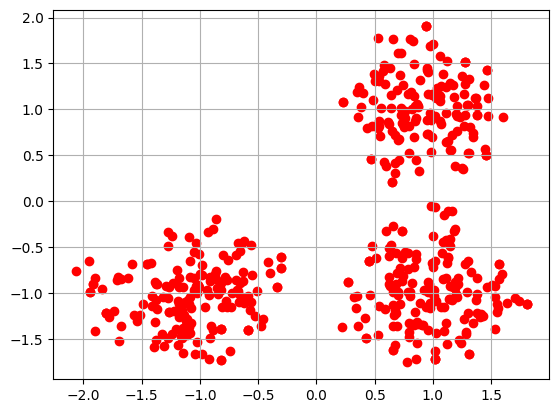

In [454]:
fig5, ax5 = plt.subplots()

ax5.scatter(x, y, c='red')
ax5.grid(True)
plt.show()